# Titanic - Machine Learning from Disaster
## Problem Statement
Predict whether a passenger survived the Titanic shipwreck based on features like age, gender, class, and more.

# Import Libraries and Set Up

In [1]:
# Import essential libraries for data handling, visualization, and modeling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# List all files in Kaggle input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic-machine-learning-from-disaster-dataset/train.csv
/kaggle/input/titanic-machine-learning-from-disaster-dataset/test.csv
/kaggle/input/titanic-machine-learning-from-disaster-dataset/gender_submission.csv


# Load and Prepare Data

In [3]:
# Load training and test datasets
train = pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster-dataset/train.csv')
test = pd.read_csv('/kaggle/input/titanic-machine-learning-from-disaster-dataset/test.csv')

# Tagging train and test for later separation after feature engineering
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.nan

# Combine datasets for unified preprocessing
all_data = pd.concat([train, test])

# EDA (Exploratory Data Analysis)

In [4]:
# Look at the data types & null counts 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [5]:
# To better understand the numeric data, we want to use the .describe() method. 
# This gives us an understanding of the central tendencies of the data 
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [7]:
# Quick way to separate numeric columns
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [8]:
# Separate numeric and categorical features
df_num = train[['Age','SibSp','Parch','Fare']]
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


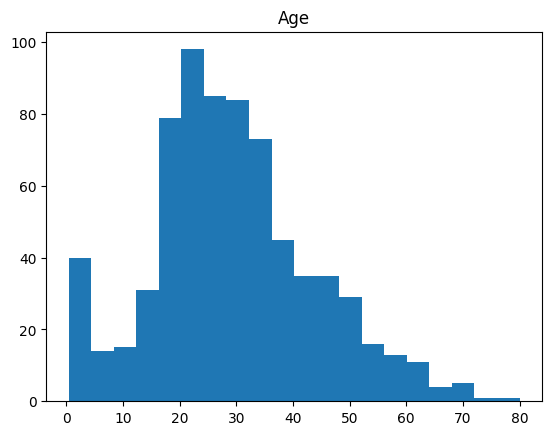

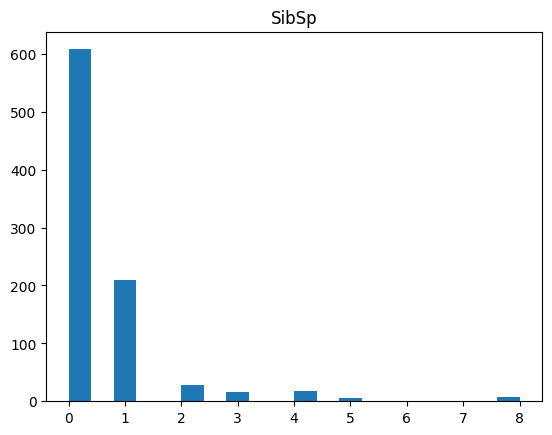

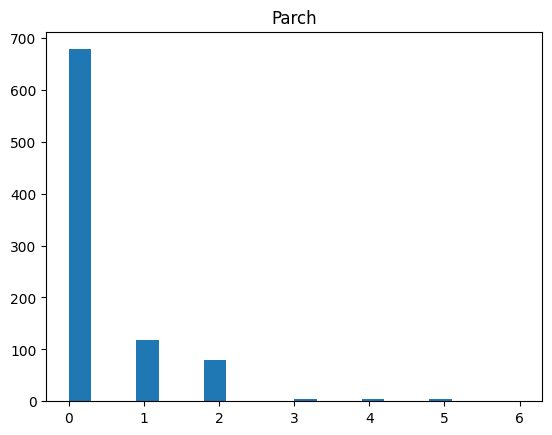

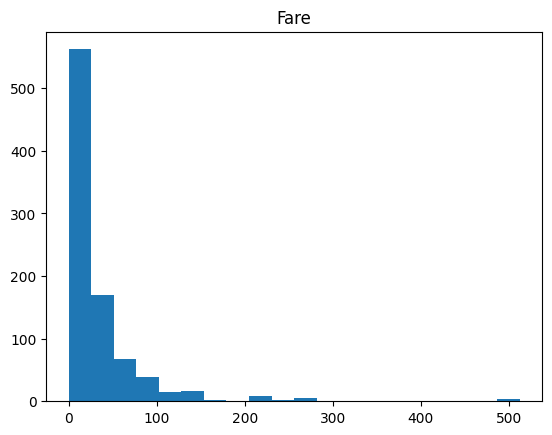

In [9]:
# Plot distributions for numeric features
for col in df_num.columns:
    plt.hist(df_num[col], bins=20)
    plt.title(col)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

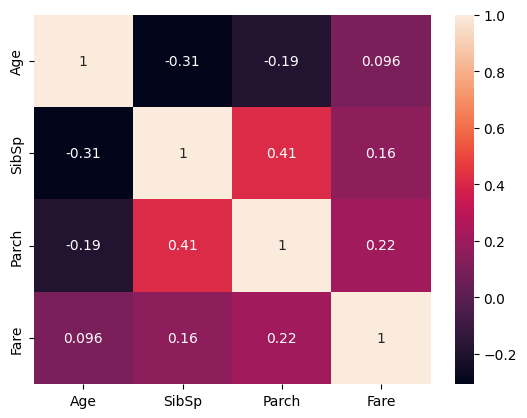

In [10]:
# Correlation matrix
print(df_num.corr())
sns.heatmap(df_num.corr(), annot=True)

In [11]:
# Survival rates across numeric features
pd.pivot_table(train, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


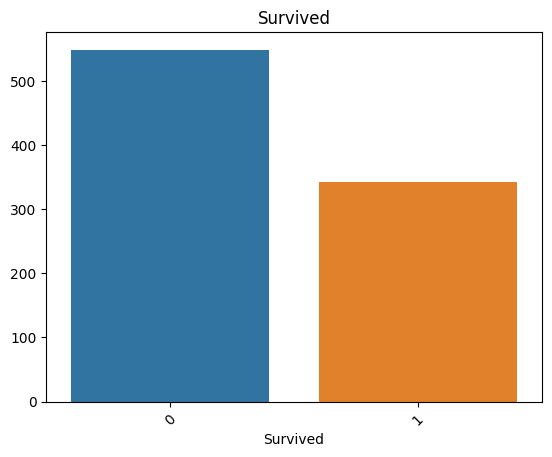

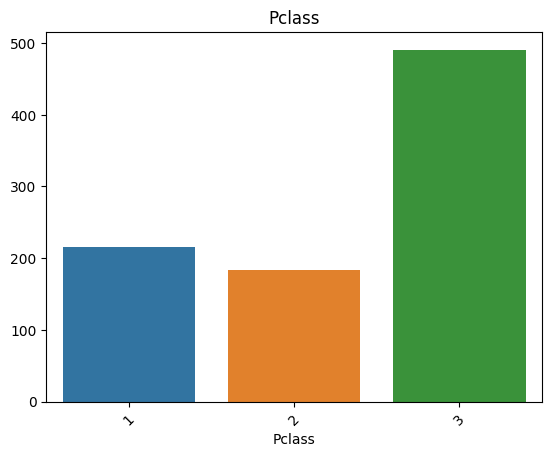

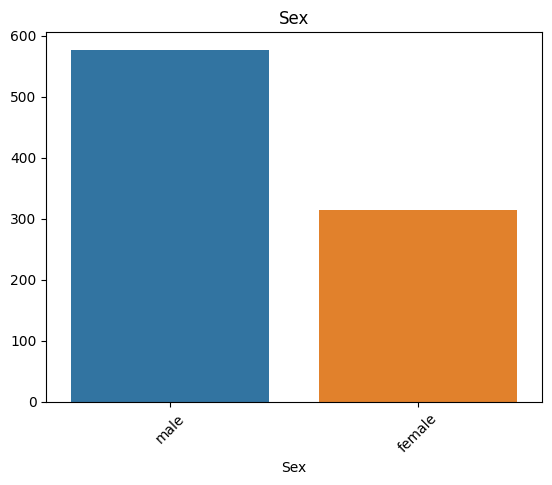

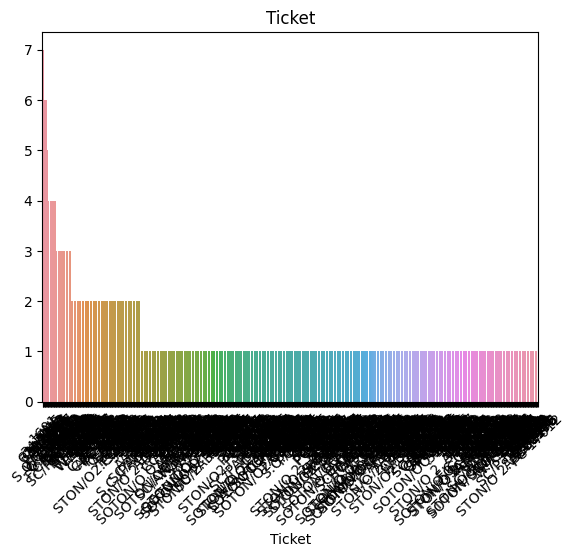

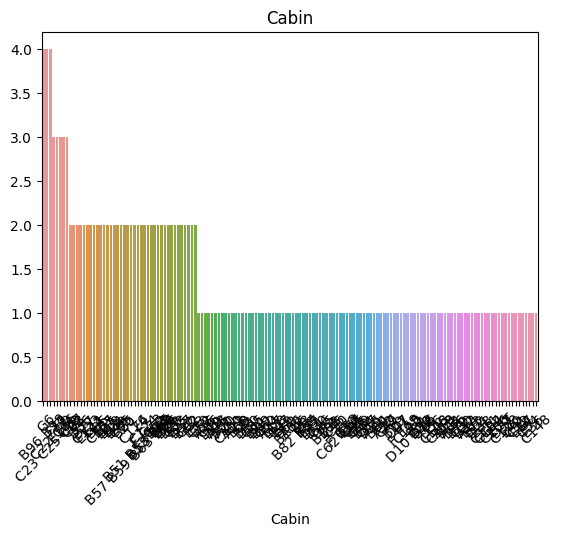

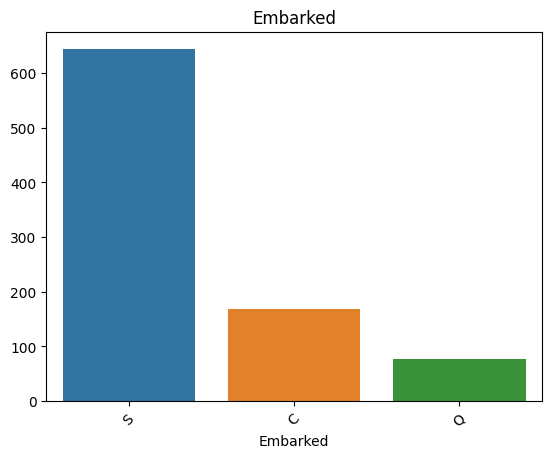

In [12]:
# Barplots for categorical features
for col in df_cat.columns:
    sns.barplot(x=df_cat[col].value_counts().index, y=df_cat[col].value_counts().values)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()
    

In [13]:
# Survival rates across categorical features
print(pd.pivot_table(train, index='Survived', columns='Pclass', values='Ticket', aggfunc='count'))
print("----------------------------")
print(pd.pivot_table(train, index='Survived', columns='Sex', values='Ticket', aggfunc='count'))
print("----------------------------")
print(pd.pivot_table(train, index='Survived', columns='Embarked', values='Ticket', aggfunc='count'))


Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
----------------------------
Sex       female  male
Survived              
0             81   468
1            233   109
----------------------------
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


# Feature Engineering

Feature Engineering¶
1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)
2) Tickets - Do different ticket types impact survival rates?
3) Does a person's title relate to survival rates?

In [14]:
# Cabin: multiple cabins
train['cabin_multiple'] = train['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [15]:
# Survival rates by multiple cabins
pd.pivot_table(train, index='Survived', columns='cabin_multiple', values='Ticket', aggfunc='count')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [16]:
# Cabin: first letter
train['cabin_adv'] = train['Cabin'].apply(lambda x: str(x)[0])

In [17]:
# Comparing survival rate by cabin
print(train['cabin_adv'].value_counts())
pd.pivot_table(train, index='Survived', columns='cabin_adv', values='Name', aggfunc='count')

cabin_adv
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [18]:
# Ticket: numeric or not, ticket prefixes
train['numeric_ticket'] = train['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
train['ticket_letters'] = train['Ticket'].apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)

In [19]:
train['numeric_ticket'].value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64

In [20]:
# View all rows in dataframe through scrolling.
pd.set_option("display.max_rows", None)
train['ticket_letters'].value_counts()

ticket_letters
0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: count, dtype: int64

In [21]:
# Survival rate: numeric vs non-numeric ticket
pd.pivot_table(train, index='Survived', columns='numeric_ticket', values='Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [22]:
# Survival rate: ticket prefixes
pd.pivot_table(train, index='Survived', columns='ticket_letters', values='Ticket', aggfunc='count')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [23]:
# Extract Title from Name (mr., ms., master. etc)
train['name_title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [24]:
train['name_title'].value_counts()

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [25]:
# Apply feature engineering to all_data
all_data['cabin_multiple'] = all_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data['Cabin'].apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data['Ticket'].apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['name_title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [26]:
# Impute missing values
all_data['Age'] = all_data['Age'].fillna(train['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(train['Fare'].median())
all_data.dropna(subset=['Embarked'], inplace=True)

In [27]:
# Normalizations
all_data['norm_sibsp'] = np.log(all_data['SibSp'] + 1)
all_data['norm_fare'] = np.log(all_data['Fare'] + 1)

In [28]:
# Prepare dummy variables
all_data['Pclass'] = all_data['Pclass'].astype(str)
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title', 'train_test']])

In [29]:
# Re-split into train and test
X_train = all_dummies[all_dummies['train_test'] == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_dummies['train_test'] == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data['train_test'] == 1]['Survived']

# Scaling Data

In [30]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']] = scale.fit_transform(all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']])

X_train_scaled = all_dummies_scaled[all_dummies_scaled['train_test'] == 1].drop(['train_test'], axis=1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled['train_test'] == 0].drop(['train_test'], axis=1)

 # Baseline Models

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [32]:
def evaluate_model(model, X, y, name="Model", scaled=True):
    cv_scores = cross_val_score(model, X, y, cv=5)
    scaled_text = " (scaled)" if scaled else ""
    print(f"{name} CV Mean Accuracy{scaled_text}: {cv_scores.mean():.4f}")

In [33]:
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": tree.DecisionTreeClassifier(random_state=1),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=1),
    "SVC": SVC(probability=True),
    "XGBoost": XGBClassifier(random_state=1)
}

In [34]:
for name, model in models.items():
    evaluate_model(model, X_train_scaled, y_train, name, False)
    evaluate_model(model, X_train, y_train, name, True)

Naive Bayes CV Mean Accuracy: 0.7222
Naive Bayes CV Mean Accuracy (scaled): 0.7255
Logistic Regression CV Mean Accuracy: 0.8223
Logistic Regression CV Mean Accuracy (scaled): 0.8223
Decision Tree CV Mean Accuracy: 0.7773
Decision Tree CV Mean Accuracy (scaled): 0.7773
KNN CV Mean Accuracy: 0.8144
KNN CV Mean Accuracy (scaled): 0.8099
Random Forest CV Mean Accuracy: 0.8009
Random Forest CV Mean Accuracy (scaled): 0.8021
SVC CV Mean Accuracy: 0.8336
SVC CV Mean Accuracy (scaled): 0.7267
XGBoost CV Mean Accuracy: 0.8110
XGBoost CV Mean Accuracy (scaled): 0.8110


# Voting Classifier

In [35]:
# A Voting Classifier combines predictions from multiple models.
# 
# - "Hard" voting: Each model votes for a class ("yes" or "no"), and the final prediction is based on majority vote.
#   (Tip: Use an odd number of models to reduce the chance of a tie.)
#
# - "Soft" voting: Each model provides a probability (confidence) for each class.
#   The final prediction is based on the average probabilities — if the average confidence for class 1 exceeds 50%, the output is 1.

from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[(name.lower().replace(' ', '_'), model) for name, model in models.items()],
    voting='soft'
)

evaluate_model(voting_clf, X_train_scaled, y_train, "Voting Classifier", False)
evaluate_model(voting_clf, X_train, y_train, "Voting Classifier", True)

Voting Classifier CV Mean Accuracy: 0.8280
Voting Classifier CV Mean Accuracy (scaled): 0.8280


In [36]:
voting_clf.fit(X_train_scaled, y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_hat_base_vc
})
submission.to_csv('base_submission.csv', index=False)

# Hyperparameter Tuning

In [37]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import uniform, randint

In [38]:
# Helper function for reporting
def clf_performance(classifier, model_name):
    print(model_name)
    print(f'Best Score: {classifier.best_score_:.4f}')
    print(f'Best Parameters: {classifier.best_params_}')

In [39]:
# Logistic Regression tuning
param_grid = {
    'max_iter': [2000],
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}

clf_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_lr = clf_lr.fit(X_train_scaled, y_train)
clf_performance(best_clf_lr, 'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8279
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [40]:
# KNN tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2]
}
clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_knn = clf_knn.fit(X_train_scaled, y_train)
clf_performance(best_clf_knn, 'KNN')


Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8291
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [41]:
# SVC tuning
# Define parameter distributions (wider ranges, but sampled randomly)
param_distributions = [
    {
        'kernel': ['rbf'],
        'gamma': uniform(0.1, 5),  # Uniform sampling between 0.1 and 5
        'C': uniform(0.1, 100)     # Uniform sampling between 0.1 and 100
    },
    {
        'kernel': ['linear'],
        'C': uniform(0.1, 100)
    },
    {
        'kernel': ['poly'],
        'degree': randint(2, 4),   # Only degree 2 or 3
        'C': uniform(0.1, 100)
    }
]

# Randomized Search instead of Grid Search
clf_svc = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions,
    n_iter=30,              # Try 30 random combinations
    cv=3,                   # Use 3-fold CV to speed up
    verbose=2,
    n_jobs=-1,
    random_state=42
)

best_clf_svc = clf_svc.fit(X_train_scaled, y_train)
clf_performance(best_clf_svc, 'SVC (Randomized)')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
SVC (Randomized)
Best Score: 0.8268
Best Parameters: {'C': 2.1584494295802448, 'degree': 3, 'kernel': 'poly'}


In [42]:
# Due to the large feature space, I first used a randomized search to quickly explore a wide range of hyperparameters.
# After identifying a promising set of parameters, I performed a more focused, granular search to fine-tune the model.

# rf = RandomForestClassifier(random_state = 1)
# param_grid =  {'n_estimators': [100,500,1000], 
#                                   'bootstrap': [True,False],
#                                   'max_depth': [3,5,10,20,50,75,100,None],
#                                   'max_features': ['auto','sqrt'],
#                                   'min_samples_leaf': [1,2,4,10],
#                                   'min_samples_split': [2,5,10]}
                                  
# clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
# best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
# clf_performance(best_clf_rf_rnd,'Random Forest')

In [43]:
# Random Forest fine-tuning
param_grid = {
    'n_estimators': [400, 450, 500, 550],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True],
    'max_depth': [15, 20, 25],
    'max_features': ['sqrt', 10],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3]
}

clf_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_rf = clf_rf.fit(X_train_scaled, y_train)
clf_performance(best_clf_rf, 'Random Forest')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Random Forest
Best Score: 0.8358
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 550}


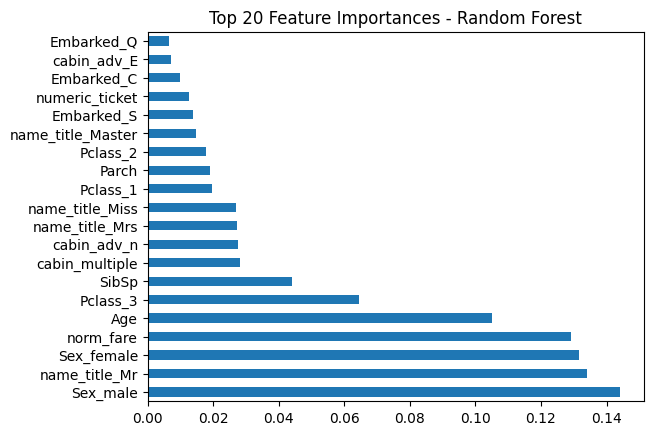

In [44]:
# Feature importances
best_rf = best_clf_rf.best_estimator_
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Feature Importances - Random Forest') 
plt.show()

In [45]:
# Due to the large feature space, I first used a randomized search to quickly explore a wide range of hyperparameters.
# After identifying a promising set of parameters, I performed a more focused, granular search to fine-tune the model.

# xgb = XGBClassifier(random_state = 1)

# param_grid = {
#     'n_estimators': [20, 50, 100, 250, 500,1000],
#     'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
#     'max_depth': [2, 5, 10, 15, 20, 25, None],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [1, 1.5, 2],
#     'subsample': [0.5,0.6,0.7, 0.8, 0.9],
#     'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
#     'gamma':[0,.01,.1,1,10,100],
#     'min_child_weight':[0,.01,0.1,1,10,100],
#     'sampling_method': ['uniform', 'gradient_based']
# }

# clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 1000, cv = 5, verbose = True, n_jobs = -1)
# best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train_scaled,y_train)
# clf_performance(best_clf_xgb_rnd,'XGB')

In [46]:
xgb = XGBClassifier(random_state=1)

param_grid = { 
    'n_estimators': [50, 100, 250, 500], 
    'colsample_bytree': [0.5, 0.7, 0.8, 1], 
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.05, 0.1, 0.3], 
    'subsample': [0.5, 0.7, 0.8, 1] 
}

clf_xgb = GridSearchCV(xgb, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1) 
best_clf_xgb = clf_xgb.fit(X_train_scaled, y_train) 
clf_performance(best_clf_xgb, 'XGBoost')

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
XGBoost
Best Score: 0.8459
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}


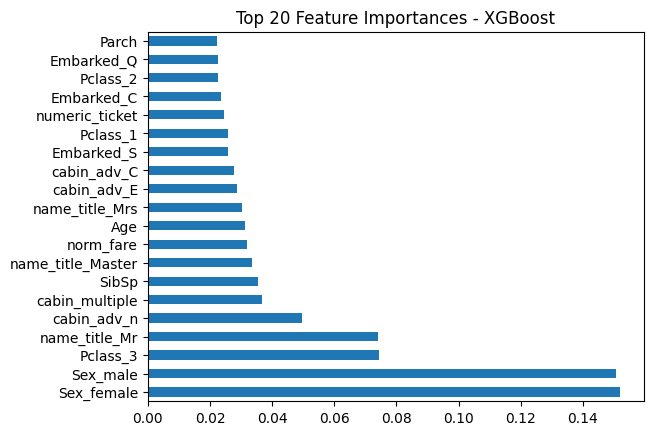

In [47]:
# Feature importance for XGBoost
best_xgb = best_clf_xgb.best_estimator_.fit(X_train_scaled, y_train) 
xgb_feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train_scaled.columns) 
xgb_feat_importances.nlargest(20).plot(kind='barh') 
plt.title('Top 20 Feature Importances - XGBoost') 
plt.show()

# Final Ensemble Model
Now that we've tuned individual models, let's create an ensemble based on the best models.

In [48]:
# Extract best estimators from grid search results
best_estimators = {
    'lr': best_clf_lr.best_estimator_,
    'knn': best_clf_knn.best_estimator_,
    'svc': best_clf_svc.best_estimator_,
    'rf': best_clf_rf.best_estimator_,
    'xgb': best_clf_xgb.best_estimator_
}

# Define different voting classifiers
voting_clf_hard = VotingClassifier(
    estimators=[('knn', best_estimators['knn']), ('rf', best_estimators['rf']), ('svc', best_estimators['svc'])],
    voting='hard'
)

voting_clf_soft = VotingClassifier(
    estimators=[('knn', best_estimators['knn']), ('rf', best_estimators['rf']), ('svc', best_estimators['svc'])],
    voting='soft'
)

voting_clf_all = VotingClassifier(
    estimators=[('knn', best_estimators['knn']), ('rf', best_estimators['rf']), 
                ('svc', best_estimators['svc']), ('lr', best_estimators['lr'])],
    voting='soft'
)

voting_clf_xgb = VotingClassifier(
    estimators=[('knn', best_estimators['knn']), ('rf', best_estimators['rf']), 
                ('svc', best_estimators['svc']), ('xgb', best_estimators['xgb']), ('lr', best_estimators['lr'])],
    voting='soft'
)

# Evaluate classifiers
for name, clf in {
    'Voting Classifier (Hard)': voting_clf_hard,
    'Voting Classifier (Soft)': voting_clf_soft,
    'Voting Classifier (Soft + LR)': voting_clf_all,
    'Voting Classifier (Soft + XGB + LR)': voting_clf_xgb
}.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"{name} CV Scores: {scores}")
    print(f"{name} Mean CV Accuracy: {scores.mean():.4f}\n")

Voting Classifier (Hard) CV Scores: [0.80337079 0.80898876 0.87078652 0.78089888 0.8700565 ]
Voting Classifier (Hard) Mean CV Accuracy: 0.8268

Voting Classifier (Soft) CV Scores: [0.80337079 0.81460674 0.84269663 0.80898876 0.86440678]
Voting Classifier (Soft) Mean CV Accuracy: 0.8268

Voting Classifier (Soft + LR) CV Scores: [0.82022472 0.81460674 0.83707865 0.80337079 0.88135593]
Voting Classifier (Soft + LR) Mean CV Accuracy: 0.8313

Voting Classifier (Soft + XGB + LR) CV Scores: [0.82022472 0.81460674 0.85393258 0.80898876 0.8700565 ]
Voting Classifier (Soft + XGB + LR) Mean CV Accuracy: 0.8336



In [49]:
# Soft voting allows weighting classifiers differently. 
# Perform grid search to find optimal weights (no new models trained here).
weight_options = {'weights': [[1,1,1], [1,2,1], [1,1,2], [2,1,1], [2,2,1], [1,2,2], [2,1,2]]}

vote_weight_search = GridSearchCV(
    estimator=voting_clf_soft,
    param_grid=weight_options,
    cv=5,
    verbose=2,
    n_jobs=-1
)

best_weighted_clf = vote_weight_search.fit(X_train_scaled, y_train)
clf_performance(best_weighted_clf, 'Voting Classifier (Weighted)')
voting_clf_sub_predictions = best_weighted_clf.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Voting Classifier (Weighted)
Best Score: 0.8347
Best Parameters: {'weights': [2, 1, 1]}


In [50]:
# Fit all voting classifiers and best random forest
models_to_fit = [voting_clf_hard, voting_clf_soft, voting_clf_all, voting_clf_xgb, best_estimators['rf']]

for model in models_to_fit:
    model.fit(X_train_scaled, y_train)

# Generate predictions
y_hat = {
    'vc_hard': voting_clf_hard.predict(X_test_scaled).astype(int),
    'vc_soft': voting_clf_soft.predict(X_test_scaled).astype(int),
    'vc_all': voting_clf_all.predict(X_test_scaled).astype(int),
    'vc_xgb': voting_clf_xgb.predict(X_test_scaled).astype(int),
    'rf': best_estimators['rf'].predict(X_test_scaled).astype(int)
}

In [51]:
# Prepare submission DataFrames
submissions = {
    'submission_rf': pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_hat['rf']}),
    'submission_vc_hard': pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_hat['vc_hard']}),
    'submission_vc_soft': pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_hat['vc_soft']}),
    'submission_vc_all': pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_hat['vc_all']}),
    'submission_vc_xgb': pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_hat['vc_xgb']})
}

# Combined comparison DataFrame
comparison = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Survived_vc_hard': y_hat['vc_hard'],
    'Survived_rf': y_hat['rf'],
    'Survived_vc_soft': y_hat['vc_soft'],
    'Survived_vc_all': y_hat['vc_all'],
    'Survived_vc_xgb': y_hat['vc_xgb']
})


In [52]:
# Compare predictions between models
comparison['diff_rf_vs_vc_hard'] = (comparison['Survived_rf'] != comparison['Survived_vc_hard']).astype(int)
comparison['diff_vc_soft_vs_hard'] = (comparison['Survived_vc_soft'] != comparison['Survived_vc_hard']).astype(int)
comparison['diff_vc_all_vs_hard'] = (comparison['Survived_vc_all'] != comparison['Survived_vc_hard']).astype(int)

In [53]:
# Show differences count
comparison['diff_vc_all_vs_hard'].value_counts()

diff_vc_all_vs_hard
0    411
1      7
Name: count, dtype: int64

In [54]:
# Save submissions
for name, df in submissions.items():
    df.to_csv(f'{name}.csv', index=False)

# Conclusion
- Performed extensive EDA and feature engineering.
- Created multiple models including Logistic Regression, KNN, SVC, Random Forest, XGBoost.
- Tuned hyperparameters using GridSearchCV.
- Built an ensemble soft-voting classifier combining the best models.
- Generated final submission ready for Kaggle.